# Customer Age Estimation

##  Project description
A retail supermarket is implementing a computer vision system to process customer photos. Capturing images at the checkout area will help determine the age of customers in order to:
 - Analyze purchases and recommend products that may be of interest to that age group;
 - Control cashier compliance when selling alcohol.
 
Task: Build a model that estimates a person's approximate age from a photo.

Data: A dataset of customer photos with age labels

## Exploratory Data Analysis

In [1]:
import pandas as pd
import numpy as np

from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

##### Data loading

In [2]:
labels=pd.read_csv('')
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [3]:
datagen = ImageDataGenerator() 

In [4]:
# Extracting data from the folder
datagen_flow = datagen.flow_from_directory(
    # Folder where the dataset is stored
    '',
    # Target image size
    target_size=(150, 150), 
    # Batch size
    batch_size=16,
    # Label format
    class_mode='sparse',
    # Random seed
    seed=12345) 

Found 7591 images belonging to 1 classes.


In [5]:
print(datagen_flow.class_indices) 

{'final_files': 0}


##### Sample Size

- The dataset includes 7,591 images. 
-  Images are represented as 4D tensors (475 batches), where each batch contains 16 images of size 150x150 with 3 color channels.

In [6]:
# 4D tensor containing 16 images of size 150x150 with three color channels
features, target = next(datagen_flow)
print(features.shape) 

(16, 150, 150, 3)


In [7]:
len(datagen_flow)

475

##### Age Distribution Chart

Age distribution: Statistical analysis shows that a quarter of people are under 20 years old, half under 29, and 75% under 41. The average age in the dataset is 31 years. The histogram of age distribution reveals two main groups: children and adults.

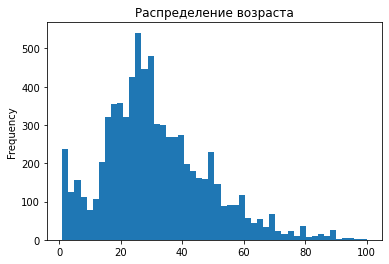

In [8]:
plot1=labels['real_age'].plot(kind='hist', bins=50, title='Распределение возраста')

##### Dataset Structure: 10–15 Photos

In [9]:
import os, random
from matplotlib.image import imread

random_images ['004251.jpg', '005758.jpg', '001875.jpg', '001699.jpg', '004790.jpg', '000422.jpg', '002811.jpg', '000732.jpg', '006934.jpg', '001564.jpg', '003302.jpg', '000412.jpg', '007310.jpg', '005933.jpg', '004528.jpg']

image_files ['/datasets/faces/final_files/004251.jpg', '/datasets/faces/final_files/005758.jpg', '/datasets/faces/final_files/001875.jpg', '/datasets/faces/final_files/001699.jpg', '/datasets/faces/final_files/004790.jpg', '/datasets/faces/final_files/000422.jpg', '/datasets/faces/final_files/002811.jpg', '/datasets/faces/final_files/000732.jpg', '/datasets/faces/final_files/006934.jpg', '/datasets/faces/final_files/001564.jpg', '/datasets/faces/final_files/003302.jpg', '/datasets/faces/final_files/000412.jpg', '/datasets/faces/final_files/007310.jpg', '/datasets/faces/final_files/005933.jpg', '/datasets/faces/final_files/004528.jpg']



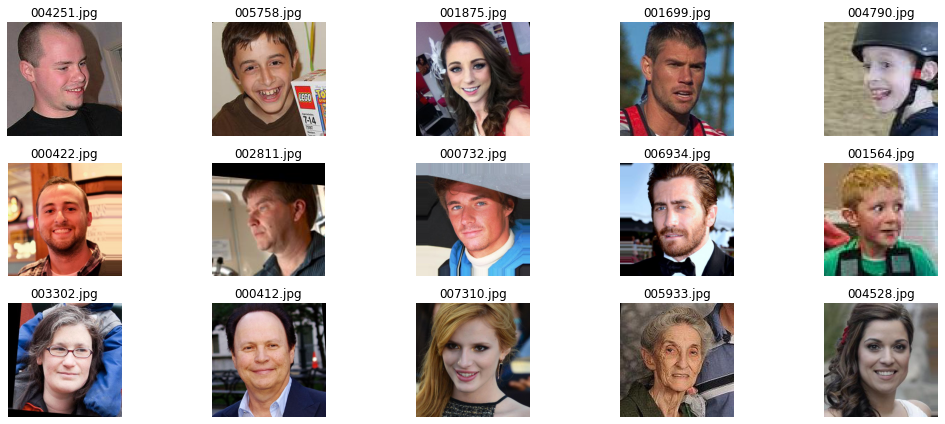

In [10]:
random_images = random.sample(
    os.listdir(''),
    k=15
)

print('random_images', random_images)
print()
# Get all image file paths
image_files = [
    os.path.join('', f) 
    for f in random_images
]

print('image_files', image_files)
print()
# Create a grid for displaying images
fig, axes = plt.subplots(3, 5, figsize=(15, 6))

# Display each image in the grid
for ax, img_path in zip(axes.flatten(), image_files):
    img = imread(img_path)
    ax.imshow(img)
    ax.axis('off')  # Hide axes
    ax.set_title(os.path.basename(img_path))  # Show image filename (optional)

plt.tight_layout()
plt.show()

Conclusions:

The analysis shows that there are no predefined classes, so this is a regression task rather than classification (with a single output neuron returning a prediction and the loss functions MAE and MSE). The ReLU activation function is suitable for age prediction, since it leaves positive values unchanged and maps negative values to zero (there is no negative age). The dataset is relatively small — 7,591 color images. Various augmentations can be applied. The age distribution follows a log-normal curve shifted to the left (towards younger customers). Consequently, the proportion of younger people in predictions may be higher.

It is also important to note the characteristics of the dataset images. There are both color and black-and-white photos. Images vary in zoom: some show only faces, others the entire body, and some include several people without clearly visible faces. Certain images are rotated or shifted. Image quality also varies, with some containing artifacts. These factors complicate the model’s task, but are not critical.

## Model Training

The notebook contains the model training code and its output results.
(The code in this section was run on a separate GPU environment, which is why it is presented as text rather than as an executable code cell.)

```python

 import os

import numpy as np
import pandas as pd
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import (
    BatchNormalization,
    Conv2D,
    Dense,
    Dropout,
    Flatten,
    GlobalAveragePooling2D,
    GlobalMaxPooling2D,
    MaxPooling2D,
)
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2


def load_train(path):
    datagen = ImageDataGenerator(validation_split=0.25, rescale=1.0 / 255,
                                 rotation_range=90,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode="nearest",
                                )
    labels=pd.read_csv(os.path.join(path, ''))

    train_datagen_flow = datagen.flow_from_dataframe(
        # Folder where the dataset is stored,
        dataframe=labels,
        x_col="file_name",
        y_col="real_age",
        directory=os.path.join(path, ''),
        # Target image size
        target_size=(150, 150),
        # Batch size
        batch_size=16 ,
        classes=None,
        # Label format
        class_mode="raw",
        # Indicate that this is the training data loader
        subset="training",
        # Random seed
        seed=12345,
    )
    return train_datagen_flow

def load_test(path):
    datagen = ImageDataGenerator(validation_split=0.25, rescale=1.0 / 255)
    labels=pd.read_csv(os.path.join(path, ''))

    val_datagen_flow = datagen.flow_from_dataframe(
        # Folder where the dataset is stored,
        dataframe=labels,
        x_col="file_name",
        y_col="real_age",
        directory=os.path.join(path, ''),
        # Target image size
        target_size=(150, 150),
        # Batch size
        batch_size=16 ,
        classes=None,
        # Label format
        class_mode="raw",
        subset="validation",
        seed=12345,
    )

    return val_datagen_flow

def create_model(input_shape):
    optimizer = Adam(learning_rate=0.00001) 
    path = ''

    # ResNet50 backbone without the top layers
    backbone = ResNet50(input_shape=(150, 150, 3),
                    weights=path if os.path.exists(path) else 'imagenet',
                    include_top=False)
    # Building the model
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(BatchNormalization())
    model.add(Dropout(0.4))

    # Fully connected network
    model.add(Dense(256, activation="relu", kernel_regularizer="l2"))
    model.add(Dropout(0.5))  # Additional regularization
    model.add(Dense(128, activation="relu", kernel_regularizer="l2"))
    model.add(Dropout(0.5))

    # Output layer
    model.add(Dense(1, activation='linear'))  # Age prediction, regression task
    
    model.compile(optimizer=optimizer, 
                   loss='mean_squared_error', 
                  metrics=['mae'])
    return model



def train_model(
    model,
    train_data,
    test_data,
    batch_size=None,
    epochs=25,
    steps_per_epoch=None,
    validation_steps=None,
):

    model.fit(
        train_data,
        validation_data=test_data,
        batch_size=batch_size,
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,
        verbose=2,
    )
    return model


if __name__ == "__main__":
    labels = pd.read_csv(r"")

    path = r""
    train_datagen_flow = load_train(path)

    val_datagen_flow = load_test(path)

    input_shape = (150, 150, 3)  
    model = create_model(input_shape)
    train_model(
        model,
        train_datagen_flow,
        val_datagen_flow,
    )
```    

```

# < copied output result here >
Found 5694 validated image filenames.
Found 1897 validated image filenames.

Train for 356 steps, validate for 119 steps
Epoch 1/25

356/356 - 106s - loss: 1084.1613 - mae: 28.0798 - val_loss: 919.7560 - val_mae: 25.4265
Epoch 2/25
356/356 - 76s - loss: 889.9902 - mae: 24.8488 - val_loss: 699.2781 - val_mae: 21.5819
Epoch 3/25
356/356 - 72s - loss: 615.6782 - mae: 20.0682 - val_loss: 231.1202 - val_mae: 11.6488
Epoch 4/25
356/356 - 72s - loss: 349.3874 - mae: 14.5632 - val_loss: 152.4129 - val_mae: 9.5609
Epoch 5/25
356/356 - 73s - loss: 259.6312 - mae: 12.3126 - val_loss: 158.5465 - val_mae: 9.5088
Epoch 6/25
356/356 - 73s - loss: 238.7720 - mae: 11.8095 - val_loss: 139.1908 - val_mae: 8.8386
Epoch 7/25
356/356 - 73s - loss: 227.3345 - mae: 11.5364 - val_loss: 129.0461 - val_mae: 8.4613
Epoch 8/25
356/356 - 76s - loss: 213.9164 - mae: 11.0792 - val_loss: 111.3144 - val_mae: 7.9295
Epoch 9/25
356/356 - 77s - loss: 209.1289 - mae: 10.9979 - val_loss: 132.9900 - val_mae: 8.6558
Epoch 10/25
356/356 - 79s - loss: 202.8597 - mae: 10.8698 - val_loss: 110.8691 - val_mae: 7.8322
Epoch 11/25
356/356 - 78s - loss: 197.8652 - mae: 10.6388 - val_loss: 111.6436 - val_mae: 7.8367
Epoch 12/25
356/356 - 79s - loss: 186.8420 - mae: 10.4367 - val_loss: 108.7572 - val_mae: 7.7028
Epoch 13/25
356/356 - 78s - loss: 180.2066 - mae: 10.1265 - val_loss: 119.3273 - val_mae: 7.9509
Epoch 14/25
356/356 - 72s - loss: 180.8386 - mae: 10.1878 - val_loss: 109.3808 - val_mae: 7.6495
Epoch 15/25
356/356 - 72s - loss: 176.4480 - mae: 9.9921 - val_loss: 111.5077 - val_mae: 7.6617
Epoch 16/25
356/356 - 73s - loss: 166.2928 - mae: 9.6828 - val_loss: 115.1434 - val_mae: 7.8189
Epoch 17/25
356/356 - 72s - loss: 165.1584 - mae: 9.7879 - val_loss: 113.5917 - val_mae: 7.7544
Epoch 18/25
356/356 - 79s - loss: 166.9420 - mae: 9.6697 - val_loss: 108.9907 - val_mae: 7.6847
Epoch 19/25
356/356 - 77s - loss: 163.4138 - mae: 9.6433 - val_loss: 113.9345 - val_mae: 7.7520
Epoch 20/25
356/356 - 78s - loss: 155.4891 - mae: 9.4050 - val_loss: 107.9959 - val_mae: 7.5331
Epoch 21/25
356/356 - 79s - loss: 162.1810 - mae: 9.5786 - val_loss: 106.5743 - val_mae: 7.4651
Epoch 22/25
356/356 - 72s - loss: 153.7422 - mae: 9.3440 - val_loss: 110.4260 - val_mae: 7.6465
Epoch 23/25
356/356 - 76s - loss: 146.6287 - mae: 9.1726 - val_loss: 103.6560 - val_mae: 7.4158
Epoch 24/25
356/356 - 77s - loss: 147.2016 - mae: 9.1717 - val_loss: 106.1355 - val_mae: 7.5407
Epoch 25/25
356/356 - 78s - loss: 150.0113 - mae: 9.1739 - val_loss: 109.0483 - val_mae: 7.6381


## Trained Model Analysis

The project consists of two main parts:
- The first part contains the results of the exploratory data analysis.
- The second part includes the model training code and its output results.
<br/><br/>
The data were loaded, and the initial dataset consisted of 7,591 images of people of different ages (both color and black-and-white). Each image had a corresponding real age label. Images were loaded using ImageDataGenerator(), which processed them in batches of 16 with a size of 150x150. Based on the analysis, there were no predefined classes, so the task was treated as regression.
<br/><br/>
A histogram of the age distribution showed: a quarter of the people were under 20, half were under 29, and 75% were under 41. The average age was 31. The histogram revealed two distinct groups: children and adults. The age distribution followed a log-normal pattern, shifted toward younger ages. Consequently, the share of younger people in the predictions was expected to be higher.
<br/><br/>
- The task was regression, with a single output neuron returning the prediction, 
- The task was regression, with a single output neuron returning the prediction,
- Metric: mae,
- Activation functions: relu (suitable for age prediction because it does not alter positive values and maps negative values to zero — negative age does not exist) and linear in the output layer,
- Data augmentation applied: rotations, shifts, zooms, flips, stretching, and the "nearest" strategy for filling newly generated pixels,
- To achieve the required MAE threshold (<8), a pre-trained ResNet50 model was used (include_top=False, backbone.trainable = False). Additional layers included: GlobalAveragePooling2D(), two fully connected layers with 256 and 128 neurons, and a final fully connected layer with one output neuron and linear activation,
- By the 10th epoch, the MAE metric on the validation data dropped to 7.8322 and did not rise above 8 afterward, which met the project’s requirements.
